<a href="https://colab.research.google.com/github/paulkarikari/chest-x-ray-image-classification-using-tensorflow/blob/master/chest_x_ray_classification_normal_and_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
The goal of this project is to classify Chest X-ray images as normal(healthy) or Pneumonia cases using Convolutional neural networks.

Convolutional Neural network is a type of Deep learning algorithm  that performs very well in image classification tasks.

# **Data**
The is hosted by Kaggle.com at this url [Data source](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) .

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
!unzip -q drive/'My Drive'/deeplearning_data/chest-xray-pneumonia.zip

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from matplotlib import pyplot as plt


## **Plot two images, normal and pneumonia chest X-ray**

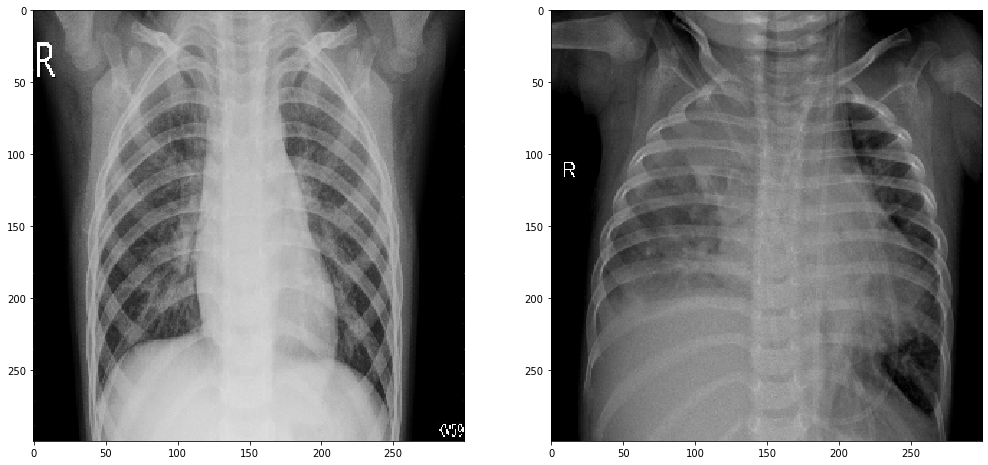

In [5]:
normal_img = load_img('chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0206-0001.jpeg', target_size=(300,300))
pneumonia_img = load_img('chest_xray/chest_xray/train/PNEUMONIA/person382_bacteria_1742.jpeg', target_size=(300,300))

fig , sp = plt.subplots(ncols=2,nrows=1, figsize=(17,17))
sp[0].imshow(normal_img)
sp[1].imshow(pneumonia_img)

## **Create image generator to extract and rescale images into classes from subdirector**

- Images are rescaled by 1/255. all train, validation , and test images needs to processed the same way.

In [0]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator


generator_params={
    'rescale': 1./255
}
train_generator = ImageDataGenerator(**generator_params)
validation_generator = ImageDataGenerator(**generator_params)
test_generator = ImageDataGenerator(**generator_params)

# Count number of train data set

In [7]:
!ls -1 'chest_xray/train/NORMAL' | wc -l 
!ls -1 'chest_xray/train/PNEUMONIA' | wc -l 

1341
3875


# Count number of validation dataset

In [8]:
!ls -1 'chest_xray/val/NORMAL' | wc -l 
!ls -1 'chest_xray/val/PNEUMONIA' | wc -l 

8
8


# Count number of test dataset

In [9]:
!ls -1 'chest_xray/test/NORMAL' | wc -l 
!ls -1 'chest_xray/test/PNEUMONIA' | wc -l 

234
390


There is more pnuemonia images than normal images in train and test subfolders

In [19]:
train_data = train_generator.flow_from_directory(
    'chest_xray/train',
    target_size=(300,300),
    shuffle=True,
    class_mode='binary',
    batch_size=64
)

val_data = train_generator.flow_from_directory(
    'chest_xray/test',
    target_size=(300,300),
    shuffle=True,
    class_mode='binary',
    batch_size=64
)

test_data = train_generator.flow_from_directory(
    'chest_xray/val',
    target_size=(300,300),
    shuffle=True,
    class_mode='binary',
    batch_size=32
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [20]:
print(train_data.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [0]:
#from the output of the image generator we can get the number of images in each subfolders
#This will be used to calculate the number of steps per epoch

num_train_img = 5216
num_test_img = 624
num_val_img = 16

# **CNN Architecture**

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [0]:
model = Sequential([
                    layers.Conv2D(64,(3,3),input_shape=(300,300,3), activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Dropout(0.2),
                    layers.Conv2D(128,(3,3), activation='relu'),
                    layers.MaxPooling2D(2,2),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(512, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(10, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation='sigmoid')
])

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 73, 73, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 682112)           

In [0]:
from tensorflow.keras.optimizers import  Adam

opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Add callback to stop at 98% accuracy

In [0]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingCallback(Callback):

  def on_epoch_end(self, epoch, log={}):
    if(log.get('acc') >= .98):
      print("\n Accuracy at 98%. Early stoping")
      self.model.stop_training = True

In [28]:
history = model.fit_generator(
    train_data,
    steps_per_epoch= num_train_img/32,
    validation_data=val_data,
    validation_steps=num_test_img/32,
    epochs=10,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/10
163/163 [==============================] - 1186s 7s/step - loss: 0.7546 - acc: 0.8069 - val_loss: 0.7643 - val_acc: 0.8446
Epoch 2/10
163/163 [==============================] - 1171s 7s/step - loss: 0.2008 - acc: 0.9262 - val_loss: 0.7287 - val_acc: 0.7853
Epoch 3/10
163/163 [==============================] - 1179s 7s/step - loss: 0.1323 - acc: 0.9521 - val_loss: 1.3927 - val_acc: 0.7548
Epoch 4/10
163/163 [==============================] - 1176s 7s/step - loss: 0.0740 - acc: 0.9747 - val_loss: 1.6463 - val_acc: 0.7420
Epoch 5/10
163/163 [==============================] - 1174s 7s/step - loss: 0.0577 - acc: 0.9774 - val_loss: 1.5921 - val_acc: 0.7804
Epoch 6/10
 20/163 [==>...........................] - ETA: 4:04 - loss: 2.3397 - acc: 0.7436
 Accuracy at 98%. Early stoping
163/163 [==============================] - 1173s 7s/step - loss: 0.0429 - acc: 0.9826 - val_loss: 2.3997 - val_acc: 0.7436


In [0]:
base_path = 'drive/My Drive/deeplearning_data/'
model.save(base_path+'chest_xray_model.h5')

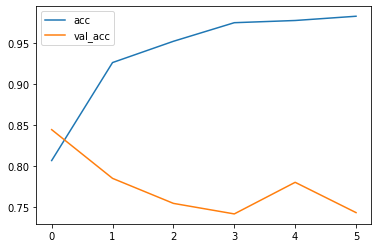

In [35]:
from matplotlib import pyplot as plt

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend(loc="upper left")
plt.show()

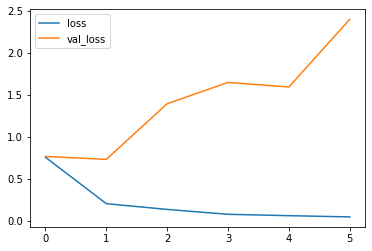

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

# **Testing model prediciton**

In [0]:
test_normal = load_img('/content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg', target_size=(300,300))
test_pneumonia = load_img('/content/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',target_size=(300,300))



In [0]:
tn_array = img_to_array(test_normal) /255
tp_array = img_to_array(test_pneumonia) /255

In [123]:
print(tn_array.shape)

(300, 300, 3)


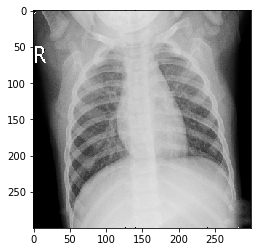

In [124]:
plt.imshow(tn_array)

In [125]:
model.predict(tn_array.reshape(-1,300,300,3)).item()

0.019411291927099228

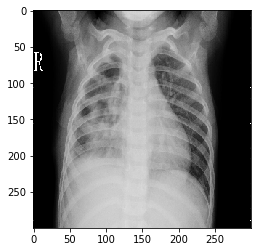

In [126]:
plt.imshow(tp_array)

In [127]:
model.predict(tp_array.reshape(-1,300,300,3)).item()

1.0

# **Conclusion**

The model can clearly classify the images as Normal or Pneumonia. More work can be  done to improve the Validation accuracy by using:
* Batch normalization
* Adjusting the learning rate and momentum
* Trying out different model architectures